# Проект e-commerce

## Project_e_commerce
### Проанализируем покупки совершенные в интернет магазине и ответим на следующие вопросы:  

**1. Сколько у нас пользователей, которые совершили покупку только один раз?**  
**2. Сколько заказов в месяц в среднем не доставляется по разным причинам? (выведем детализацию по причинам)**  
**3. По каждому товару определить, в какой день недели товар чаще всего покупается**  
**4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)?**  
**5. Выполним когортный анализ пользователей.  
    В период с января по декабрь найдем когорту с самым высоким retention на 3-й месяц**  
**6. Для качественного анализа аудитории используем подходы, основанные на сегментации.   
Построим RFM-сегментацию пользователей.  
В кластеризации выберем следующие метрики:**  
R - время от последней покупки пользователя до текущей даты  
F - суммарное количество покупок у пользователя за всё время   
M - сумма покупок за всё время

## данные проекта e-commerce  

### customers  - таблица с уникальными идентификаторами пользователей

customer_id — позаказный идентификатор пользователя  
customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)  
customer_zip_code_prefix —  почтовый индекс пользователя  
customer_city —  город доставки пользователя  
customer_state —  штат доставки пользователя  

### orders - таблица заказов

order_id —  уникальный идентификатор заказа (номер чека)  
customer_id —  позаказный идентификатор пользователя  
order_status —  статус заказа  
order_purchase_timestamp —  время создания заказа  
order_approved_at —  время подтверждения оплаты заказа  
order_delivered_carrier_date —  время передачи заказа в логистическую службу  
order_delivered_customer_date —  время доставки заказа  
order_estimated_delivery_date —  обещанная дата доставки  

#### order_status —  статус заказа:      
created —  создан  
approved —  подтверждён  
invoiced —  выставлен счёт  
processing —  в процессе сборки заказа  
shipped —  отгружен со склада  
delivered —  доставлен пользователю  
unavailable —  недоступен  
canceled —  отменён  

### order_items - товарные позиции, входящие в заказы

order_id —  уникальный идентификатор заказа (номер чека)  
order_item_id —  идентификатор товара внутри одного заказа  
product_id —  ид товара (аналог штрихкода)  
seller_id — ид производителя товара  
shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике  
price —  цена за единицу товара  
freight_value —  вес товара  

## загрузим данные и сделаем предварительную обработку  


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta

In [3]:
customers  = pd.read_csv('olist_customers_dataset.csv')
orders     = pd.read_csv('olist_orders_dataset.csv', 
                         parse_dates=['order_purchase_timestamp', 
                                      'order_approved_at',
                                      'order_delivered_carrier_date', 
                                      'order_delivered_customer_date', 
                                      'order_estimated_delivery_date'])

order_items = pd.read_csv('olist_order_items_dataset.csv', 
                          parse_dates=['shipping_limit_date'])



In [4]:
# посмотрим на типы колонок, пропущенные значения, количество строк

print(customers.info())
print(orders.info())
print(order_items.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purch

In [5]:
# проверим на дубликаты

duplicateRows1 = customers[customers.duplicated()]
duplicateRows2 = orders[orders.duplicated()]
duplicateRows3 = order_items[order_items.duplicated()]

print(duplicateRows1)
print(duplicateRows2)
print(duplicateRows3)

Empty DataFrame
Columns: [customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state]
Index: []
Empty DataFrame
Columns: [order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date]
Index: []
Empty DataFrame
Columns: [order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value]
Index: []


In [6]:
# уточним за какой период указаны данные по заказам в таблице

orders['order_purchase_timestamp'].agg(['min', 'max'])
# согласно полученным данным клиенты делали заказы с 2016-09-04 по 2018-10-17

min   2016-09-04 21:15:19
max   2018-10-17 17:30:18
Name: order_purchase_timestamp, dtype: datetime64[ns]

## результаты предварительной обработки  

**в таблице customers  (уникальные идентификаторы пользователей)** пропущенных значений нет, дубликатов нет, типы колонок соответствуют

**в таблице order_items  (товарные позиции, входящие в заказы)** пропущенных значений нет, дубликатов нет, типы колонок соответствуют

**в таблице orders  (таблица заказов)** дубликатов нет, типы колонок соответствуют Пропущенные значения имеют место быть, так как это жизненные циклы заказов(подтверждение оплаты, передача в доставку, время доставки заказа)

## 1. Определим количество пользователей, совершивших только одну покупку

Для начала определим, что мы будем считать **покупкой**.   
тк наш проект e-commerce, то право собственности на товар (при продаже товара через интернет-магазин с условием доставке товара покупателю) переходит к покупателю в момент получения товара непосредственно покупателем (ОБОСНОВАНИЕ: Согласно ч.1 ст. 223 ГК РФ право собственности у приобретателя вещи по договору возникает с момента ее передачи, если иное не предусмотрено законом или договором.)

**Таким образом, будeм считать покупку товара совершенной, если есть факт доставки, а именно время доставки заказа не пустое.**

In [7]:
# Посмотрим на заказы, доставленные покупателям (покупки) 
# Для этого объединим таблицы пользователей и заказов по полю 'customer_id' и 
# отберем строки, в которых есть время доставки заказа

purchases = customers.merge(orders, how='inner', on='customer_id')\
                    .query('order_delivered_customer_date != "NaT"')
purchases.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [8]:
# посмотрим на статусы заказов в purchases (покупках)
# для этого сгруппируем доставленные заказы по статусу заказа

purchases.groupby('order_status', as_index=False)  \
            .agg({'customer_id':'count'})

# покупки имеют статусы delivered (доставлен) и canceled (отменен). 
# статус canceled стоит у тех покупок, которые были доставлены и покупатель отменил заказ
# после доставки

,order_status,customer_id
0,canceled,6
1,delivered,96470


In [9]:
# Определим количество пользователей, совершивших только одну покупку

purchases.groupby('customer_unique_id', as_index=False).agg({'customer_id':'count'})\
            .query('customer_id == 1').count()

customer_unique_id    90555
customer_id           90555
dtype: int64

### за период с 2016-09-04 по 2018-10-17 из общего числа уникальных пользователей 99441, количество пользователей совершивших только одну покупку 90555,  что составляет 91 %

##  2. Рассмотрим какое количество заказов в месяц в среднем не доставляется по разным причинам (выведем детализацию по причинам)

In [10]:
# из таблицы заказов возьмем те заказы которые были оформлены, но не доставлены пользователю.

orders_not_delivered = orders.query("order_status != 'delivered'")

# посмотрим какие статусы получились

orders_not_delivered.order_status.value_counts()

order_status
shipped        1107
canceled        625
unavailable     609
invoiced        314
processing      301
created           5
approved          2
Name: count, dtype: int64

In [11]:
# т.к. статусы: created, approved, invoiced, processing, shipped -
# это текущие этапы работы с заказом, 
# для анализа недоставленных заказов возьму статусы canceled и unavailable

orders_not_delivered = orders_not_delivered.query("order_status == 'canceled' or order_status == 'unavailable'")

# для группировки заказов по месяцам, сконвертируем время создания заказа в месяц и год

orders_not_delivered['order_purchase_timestamp'] = orders_not_delivered['order_purchase_timestamp']\
                                                    .dt.to_period('M')

# сгруппируем по месяцам и статусу недоставленного заказа, посчитаем количество недоставленных заказов по группам
# переименуем колонки в новом датафрейме
# преобразуем датафрейм в таблицу где статусы недоставленного заказа сделаем столбцами
# пустые значения заменим на нули

orders_not_delivered = orders_not_delivered.groupby(['order_purchase_timestamp', 'order_status'], as_index=False)\
                        .agg({'order_id': 'count'})\
                        .rename(columns={'order_purchase_timestamp' : 'date', 'order_id' : 'events'})\
                        .pivot(index = 'date', columns= 'order_status', values = 'events')\
                        .fillna(0)

# создадим итоговую колонку недоставленных заказов по месяцам 

orders_not_delivered['total'] = orders_not_delivered.sum (axis=1)

# теперь можем посчитать средний по недоставленным заказам по разным причинам и по группам

orders_not_delivered.mean().round(0)

order_status
canceled       26.0
unavailable    25.0
total          51.0
dtype: float64

###  в среднем в месяц не доставляется 51 заказ в т.ч. 26 заказов по причине canceled (отмена) и 25 заказов по причине unavailable (недоступен) 

## 3. Определим по каждому товару, в какой день недели товар чаще всего покупается 
#### (здесь буду использовать дату создания заказа (order_purchase_timestamp))

In [12]:
# для этого добавим к обьединенной таблице пользователей и заказов (purchases)
# добавим данные о товарных позициях

total = purchases.merge(order_items, how='left', on='order_id')
total.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [13]:
# тк этот df  пригодится нам в дальнейшем, сделаем копию, 
# с которой и будем сейчас работать

total_copy = total.copy(deep=True)

In [14]:
# создадим колонку с днем недели заказа

total_copy['weekday'] = total_copy['order_purchase_timestamp'].dt.strftime('%A') 

# посчитаем кол-во заказов по товару и дням недели

number_purchases = total_copy.groupby(['product_id', 'weekday'], as_index=False)\
            .agg({'seller_id': 'count'}).rename(columns={'seller_id':'count_orders'})
number_purchases.head()

,product_id,weekday,count_orders
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1


In [15]:
# посчитаем по уникальными id товара и максимальное значение покупок в день

# создание датафрейма с уникальными id товара и максимальним значением покупки в день
purchases_max = number_purchases.groupby('product_id', as_index=False)\
                .agg({'count_orders':'max'}) 
purchases_max.head()

,product_id,count_orders
0,00066f42aeeb9f3007548bb9d3f33c38,1
1,00088930e925c41fd95ebfe695fd2655,1
2,0009406fd7479715e4bef61dd91f2462,1
3,000b8f95fcb9e0096488278317764d19,1
4,000d9be29b5207b54e86aa1b1ac54872,1


In [16]:
# тк у нас могут быть товары, у которых больше чем один день недели 
# с максимальным количеством заказов
# объединеним данные по кол-ву заказов по товару и дням недели 
# и максимальному значению покупок в день

purchases_max_total = number_purchases.merge(purchases_max, how='inner', on=['product_id', 'count_orders'])

# получили таблицу с product_id и с днем (днями) недели, когда его чаще всего покупают

purchases_max_total.sort_values('count_orders', ascending = False).head(10)

,product_id,weekday,count_orders
10885,422879e10f46682990de24d770e7f83d,Wednesday,93
24832,99a4788cb24856965c36a24e339b6058,Monday,91
27841,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
13683,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
8874,368c6c730842d78016ad823897a372db,Friday,67
9241,389d119b48cf3043d311335e499d9c6b,Thursday,67
13650,53759a2ecddad2bb87a079a1f1519f73,Wednesday,66
34206,d1c427060a0f73f6b889a5c7c61f2ac4,Monday,62
10131,3dd2a17168ec895c781a9191c1e95ad7,Wednesday,53
26800,a62e25e09e05e6faf31d90c6ec1aa3d1,Thursday,49


In [17]:
# пример товара с одинаковым максимальным количестовом покупок во все дни недели
purchases_max_total.query('product_id == "d4fe034cde911805af12724d73fde7e0"')

,product_id,weekday,count_orders
34772,d4fe034cde911805af12724d73fde7e0,Friday,1
34773,d4fe034cde911805af12724d73fde7e0,Monday,1
34774,d4fe034cde911805af12724d73fde7e0,Saturday,1
34775,d4fe034cde911805af12724d73fde7e0,Sunday,1
34776,d4fe034cde911805af12724d73fde7e0,Thursday,1
34777,d4fe034cde911805af12724d73fde7e0,Tuesday,1
34778,d4fe034cde911805af12724d73fde7e0,Wednesday,1


## 4. Посчитаем сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)

In [18]:
# возмем наш обьединенный df с данными пользователей, заказами и товарными позициями
# сделаем копию для дальнейшей обработки данных

total_copy1 = total.copy(deep=True)

In [19]:
# отфильтруем строки с пустыми датами доставки
# добавим колонку с месяцем покупки и колонку с количеством недель в месяце

total_copy1 = total_copy1.query('order_delivered_customer_date != "NaT"') 

total_copy1['month'] = total_copy1['order_delivered_customer_date'].dt.strftime('%B')
total_copy1['week_in_month'] = total_copy1.order_delivered_customer_date.dt.daysinmonth/7

total_copy1.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,month,week_in_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,May,4.428571
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,January,4.428571
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,June,4.285714
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,March,4.428571
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,August,4.428571


In [20]:
# Посчитаем количество покупок по каждому покупателю и каждому заказу для покупателя. 
# В группировке у одного покупателя может быть два одинаковых месяца, 
# т.к. они из разных годов покупок

purchases_month = total_copy1.groupby(['customer_unique_id', 'order_id', 'month', 'week_in_month'], as_index=False)\
                            .agg({'order_item_id':'count'})\
                            .rename(columns={'order_item_id':'count_purchase'})

# Подсчитаем среднее количество покупок в неделю у каждого пользователя
# данные запишем в новую колонку 'avr_purchases_month' 

purchases_month['avr_purchases_month'] = purchases_month.count_purchase/purchases_month.week_in_month

purchases_month.head()

,customer_unique_id,order_id,month,week_in_month,count_purchase,avr_purchases_month
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,May,4.428571,1,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,May,4.428571,1,0.225806
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,April,4.285714,1,0.233333
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,November,4.285714,1,0.233333
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,November,4.285714,1,0.233333


In [21]:
# Сгруппируем по месяцам и подсчитаем среднее количество покупок в неделю
# по каждому пользователю по месяцам

avr_purchases_month = purchases_month.groupby(['customer_unique_id', 'month'], as_index=False)\
                    .agg({'avr_purchases_month':'mean'})

# посмотрим на ТОП 10 средних покупок в неделю
avr_purchases_month.sort_values('avr_purchases_month', ascending=False).head(10)

,customer_unique_id,month,avr_purchases_month
25802,4546caea018ad8c692964e3382debd19,July,4.741935
39334,698e1cf81d01a3d389d96145f7fa6df8,September,4.666667
73034,c402f431464c72e27330a67f7b94d4fb,March,4.516129
6740,11f97da02237a49c8e783dfda6f50e8e,February,3.750000
18620,31e412b9fb766b6794724ed17a41dfa6,December,3.161290
92338,f7ea4eef770a388bd5b225acfc546604,March,3.161290
43776,7582a5a77fc2976628f46a13ec91b375,April,3.033333
28894,4d99682572b7b5932340a0bce676c18c,June,2.800000
76946,ce9f8b9c31d83341764708396ac7e38b,October,2.709677
59150,9eca552063680b7cd2ed0e8aea002b21,January,2.709677


## 5. Проведем когортный анализ пользователей и найдем когорту с самым высоким retention на 3-й месяц в период с января по декабрь 

In [22]:
# возмем наш обьединенный df с данными пользователей, заказами и товарными позициями
# сделаем копию для дальнейшей обработки данных

total_copy2 = total.copy(deep=True)

# удалим лишние столбцы в df не нужные нам для когортного анализа
total_copy2 = total_copy2.drop(columns=['order_id', 'order_status', 'customer_id', 
                                                         'order_approved_at', 'order_delivered_carrier_date',
                                                         'order_purchase_timestamp',
                                                         'order_estimated_delivery_date',
                                                         'customer_zip_code_prefix',
                                                         'customer_city', 'customer_state', 
                                                         'seller_id', 'shipping_limit_date',
                                                         'price', 'freight_value', 'order_item_id'])   
total_copy2.head()

,customer_unique_id,order_delivered_customer_date,product_id
0,861eff4711a542e4b93843c6dd7febb0,2017-05-25 10:35:35,a9516a079e37a9c9c36b9b78b10169e8
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-29 12:41:19,4aa6014eceb682077f9dc4bffebc05b0
2,060e732b5b29e8181a18229c7b0b2b5e,2018-06-14 17:58:51,bd07b66896d6f1494f5b86251848ced7
3,259dac757896d24d7702b9acbbff3f3c,2018-03-28 16:04:25,a5647c44af977b148e0a3a4751a09e2e
4,345ecd01c38d18a9036ed96c73b8d066,2018-08-09 20:55:48,9391a573abe00141c56e38d84d7d5b3b


In [23]:
# Дата покупки определена мной как order_delivered_customer_date —  время доставки заказа
# отфильтруем строки с пустыми датами доставки

total_copy2 = total_copy2.query('order_delivered_customer_date != "NaT"')

# cконвертируем время доставки товара в месяц и год

total_copy2['order_delivered_customer_date'] = total_copy2['order_delivered_customer_date'].dt.to_period('M')
total_copy2.head()

,customer_unique_id,order_delivered_customer_date,product_id
0,861eff4711a542e4b93843c6dd7febb0,2017-05,a9516a079e37a9c9c36b9b78b10169e8
1,290c77bc529b7ac935b93aa66c333dc3,2018-01,4aa6014eceb682077f9dc4bffebc05b0
2,060e732b5b29e8181a18229c7b0b2b5e,2018-06,bd07b66896d6f1494f5b86251848ced7
3,259dac757896d24d7702b9acbbff3f3c,2018-03,a5647c44af977b148e0a3a4751a09e2e
4,345ecd01c38d18a9036ed96c73b8d066,2018-08,9391a573abe00141c56e38d84d7d5b3b


In [24]:
# теперь посчитаем для каждого клиента дату первой покупки
# получившийся результат запишем в новый df purchases_customers_first
# колонку месяц первой покупки назовем cohort
purchases_customers_first = total_copy2.groupby('customer_unique_id', as_index=False)\
                            .agg({'order_delivered_customer_date' : 'min' })\
                            .rename(columns={'order_delivered_customer_date': 'cohort'})

purchases_customers_first.head()

,customer_unique_id,cohort
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05
2,0000f46a3911fa3c0805444483337064,2017-04
3,0000f6ccb0745a6a4b88665a16c9f078,2017-11
4,0004aac84e0df4da2b147fca70cf8255,2017-11


In [25]:
# соединим датасет покупок purchases_customers_2 и датасет первых покупок по customer_unique_id
cohort = total_copy2.merge(purchases_customers_first,how='left',on = 'customer_unique_id')

cohort.head()

,customer_unique_id,order_delivered_customer_date,product_id,cohort
0,861eff4711a542e4b93843c6dd7febb0,2017-05,a9516a079e37a9c9c36b9b78b10169e8,2017-05
1,290c77bc529b7ac935b93aa66c333dc3,2018-01,4aa6014eceb682077f9dc4bffebc05b0,2018-01
2,060e732b5b29e8181a18229c7b0b2b5e,2018-06,bd07b66896d6f1494f5b86251848ced7,2018-06
3,259dac757896d24d7702b9acbbff3f3c,2018-03,a5647c44af977b148e0a3a4751a09e2e,2018-03
4,345ecd01c38d18a9036ed96c73b8d066,2018-08,9391a573abe00141c56e38d84d7d5b3b,2018-08


In [26]:
# проверим все ли правльно получилось

cohort.query('customer_unique_id == "7c396fd4830fd04220f754e42b4e5bff"')
# да все верно, в нашем примере клиент делал покупки два раза, первая покупка 09-2017

,customer_unique_id,order_delivered_customer_date,product_id,cohort
77854,7c396fd4830fd04220f754e42b4e5bff,2017-10,87285b34884572647811a353c7ac498a,2017-09
83089,7c396fd4830fd04220f754e42b4e5bff,2017-09,9abb00920aae319ef9eba674b7d2e6ff,2017-09


In [27]:
# отфильтруем дату первой покупки 2017 годом, 
# так как нам нужно найти кагорту с самым высоким retention 
# на 3-й месяц в период с января по декабрь 
# cгруппируем даты и посчитаем кол-во уникальных id пользователей

cohort = cohort.query("'2017-01' <= cohort <= '2017-12'")\
     .groupby(['cohort', 'order_delivered_customer_date'], as_index=False)\
     .agg({'customer_unique_id': 'nunique'})

cohort.head()

,cohort,order_delivered_customer_date,customer_unique_id
0,2017-01,2017-01,263
1,2017-01,2017-02,3
2,2017-01,2017-03,1
3,2017-01,2017-05,1
4,2017-01,2017-06,1


In [28]:
# теперь посчитаем разницу между датой первой покупки и cледующей покупкой клиента
# в месяцах

def diff_month(x):
    d1 = x['order_delivered_customer_date']
    d2 = x['cohort']
    return ((d1.year - d2.year) * 12 + d1.month - d2.month)
cohort['cohort_idx'] = cohort.apply(lambda x: diff_month(x), axis=1)

cohort.head()

,cohort,order_delivered_customer_date,customer_unique_id,cohort_idx
0,2017-01,2017-01,263,0
1,2017-01,2017-02,3,1
2,2017-01,2017-03,1,2
3,2017-01,2017-05,1,4
4,2017-01,2017-06,1,5


In [29]:
# преобразуем наш датасет в таблицу через pivot, заменим пустые значения на нули
cohort = cohort.pivot(index='cohort', columns = 'cohort_idx', values = 'customer_unique_id')\
                .fillna(0)

cohort.head()

cohort_idx,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
cohort,,,,,,,,,,,,,,,,,,,,
2017-01,263.0,3.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,3.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0
2017-02,1325.0,9.0,3.0,4.0,4.0,2.0,2.0,3.0,1.0,1.0,2.0,5.0,3.0,2.0,1.0,2.0,3.0,0.0,1.0,0.0
2017-03,2344.0,13.0,7.0,10.0,7.0,2.0,7.0,6.0,7.0,5.0,6.0,1.0,1.0,7.0,3.0,4.0,3.0,2.0,0.0,0.0
2017-04,1804.0,14.0,5.0,4.0,5.0,3.0,5.0,1.0,7.0,4.0,5.0,2.0,0.0,2.0,2.0,3.0,3.0,0.0,0.0,0.0
2017-05,3673.0,27.0,12.0,6.0,13.0,14.0,9.0,13.0,8.0,8.0,9.0,11.0,5.0,6.0,7.0,8.0,0.0,0.0,0.0,0.0


In [30]:
# теперь посчитаем Retention 
# Retention измеряется в процентах, 
# показывает долю вернувшихся людей от изначально пришедших.

retention = cohort 

# разделим количество людей сделавших повторные покупки, на количество людей
# сделавших покупки

retention = round(retention.div(retention.iloc[:,0], axis = 0).mul(100), 2)
retention.head()
# ретеншен получился очень низкий, большинство клиентов совершили покупку один раз,
# это подтверждается и анализом проведенным выше, мы видим, что 
# большинство клиентов уникальны, они сделали покупку в магазине только один раз

cohort_idx,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
cohort,,,,,,,,,,,,,,,,,,,,
2017-01,100.0,1.14,0.38,0.00,0.38,0.38,0.38,0.38,0.00,0.00,0.38,0.76,1.14,0.00,0.38,0.00,0.00,0.76,0.00,0.38
2017-02,100.0,0.68,0.23,0.30,0.30,0.15,0.15,0.23,0.08,0.08,0.15,0.38,0.23,0.15,0.08,0.15,0.23,0.00,0.08,0.00
2017-03,100.0,0.55,0.30,0.43,0.30,0.09,0.30,0.26,0.30,0.21,0.26,0.04,0.04,0.30,0.13,0.17,0.13,0.09,0.00,0.00
2017-04,100.0,0.78,0.28,0.22,0.28,0.17,0.28,0.06,0.39,0.22,0.28,0.11,0.00,0.11,0.11,0.17,0.17,0.00,0.00,0.00
2017-05,100.0,0.74,0.33,0.16,0.35,0.38,0.25,0.35,0.22,0.22,0.25,0.30,0.14,0.16,0.19,0.22,0.00,0.00,0.00,0.00


<Axes: xlabel='cohort_idx', ylabel='cohort'>

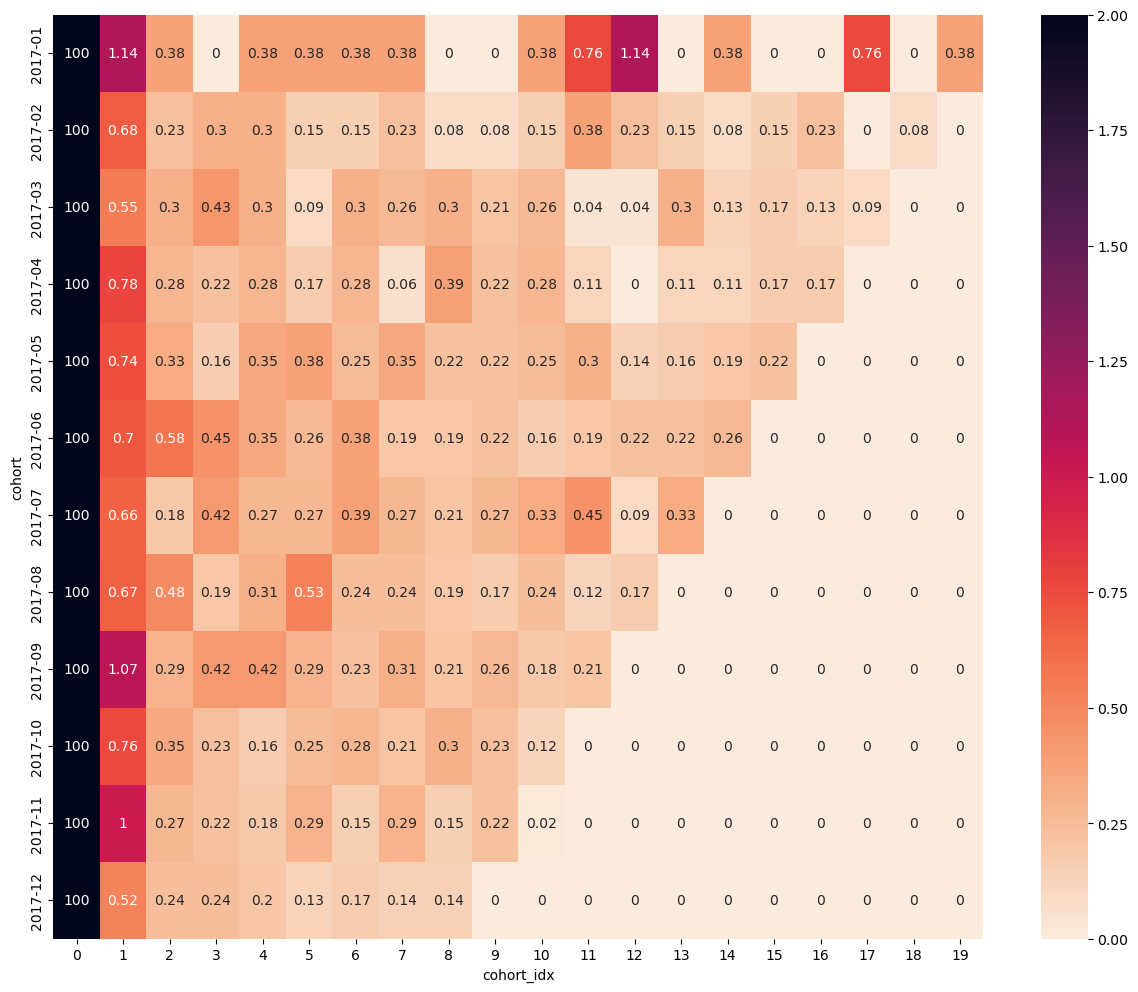

In [34]:
# построим тепловую карту
# тепловая карта подтверждает сделанный вывод, карта темная, так как мы получили очень низкий ретеншен

cmap = sns.cm.rocket_r
plt.figure(figsize = (15, 12))
sns.heatmap(retention, annot = True, fmt = '.3g', vmin=0, vmax=2, cmap=cmap)

In [35]:
#найдем когорту с максимальным значением retention на третий месяц 

retention[3].sort_values( ascending=False).head(1)

# в нашем случае самый высокий процент вернувшихся покупателей на третий месяц, 
# был среди тех, кто сделал свою первую покупку в июне 2017 года

cohort
2017-06    0.45
Freq: M, Name: 3, dtype: float64

### в целом ретеншен получился низкий, большинство клиентов совершили покупку один раз, это подтверждается и анализом проведенным выше, мы видим, что большинство клиентов уникальны, т.е. они делали  только одну покупку в магазине

## Построим RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 

### В кластеризации выберем следующие метрики:  

**R - время от последней покупки пользователя до текущей даты**   
**F - суммарное количество покупок у пользователя за всё время**   
**M - сумма покупок за всё время**

### Для каждого RFM-сегмента построим границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

In [36]:
# возмем наш обьединенный df с данными пользователей, заказами и товарными позициями
# сделаем копию для дальнейшей обработки данных

total_copy3 = total.copy(deep=True)

# Дата покупки определена мной как order_delivered_customer_date —  время доставки заказа
# отфильтруем строки с пустыми датами доставки

total_copy3 = total_copy3.query('order_delivered_customer_date != "NaT"')

# cконвертируем время доставки товара в месяц и год

total_copy3['delivered_date'] = total_copy3['order_delivered_customer_date'].dt.strftime('%Y-%m') 

total_copy3.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,delivered_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,2018-06
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,2018-08


In [37]:
# сформируем таблицу с заказами

orders = total_copy3.groupby(['order_id', 'order_delivered_customer_date', 'customer_unique_id'], as_index=False)  \
                    .agg({'price': 'sum'})
orders.head()

,order_id,order_delivered_customer_date,customer_unique_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-20 23:43:48,871766c5855e863f6eccc05f988b23cb,58.90
1,00018f77f2f0320c557190d7a144bdd3,2017-05-12 16:04:24,eb28e67c4c0b83846050ddfb8a35d051,239.90
2,000229ec398224ef6ca0657da4fc703e,2018-01-22 13:19:16,3818d81c6709e39d06b2738a8d3a2474,199.00
3,00024acbcdf0a6daa1e931b038114c75,2018-08-14 13:32:39,af861d436cfc08b2c2ddefd0ba074622,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-03-01 16:42:31,64b576fb70d441e8f1b2d7d446e483c5,199.90


In [38]:
# Для расчета R (времени с последней покупки) нам нужна текущая дата. 
# Смоделируем проведение RFM-анализа на дату сразу после окончания периода

NOW = orders['order_delivered_customer_date'].max() + timedelta(days=1)
NOW

Timestamp('2018-10-18 13:22:46')

In [39]:
# Добавим столбец с количеством дней между покупкой и NOW. 
# Далее чтобы найти значения R - нужно будет найти минимум этого
# столбца для каждого клиента.

orders['days_after_last_order'] = orders['order_delivered_customer_date'].apply(lambda x: (NOW - x).days)

In [40]:
# Сгруппируем данные по клиентам и посчитаем R, F и M

RFM = orders.groupby('customer_unique_id', as_index=False)\
            .agg({'days_after_last_order':'min',\
                  'order_delivered_customer_date': 'count',\
                 'price':'sum'})

RFM.rename(columns={'days_after_last_order': 'Recency', 'order_delivered_customer_date': 'Frequency', 'price':'Monetary'}, inplace=True)
RFM.head()

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,154,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,160,1,18.90
2,0000f46a3911fa3c0805444483337064,560,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,350,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,324,1,180.00


In [41]:
# Чтобы вывести ранги для данных - необходимо разбить данные на диапазоны. 
# Используем перцентили, отсекающие по 20% пользователей

level = [0.2, 0.4, 0.6, 0.8]
quantiles = RFM[['Recency', 'Frequency', 'Monetary']].quantile(level).to_dict()

quantiles

{'Recency': {0.2: 128.0, 0.4: 209.0, 0.6: 301.0, 0.8: 419.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 39.9, 0.4: 69.9, 0.6: 109.9, 0.8: 179.9}}

In [42]:
# Присвоим ранги для Recency 
# чем меньше дней прошло от последней покупки до now тем лучше


intervals_R=[0]
for i in range(len(quantiles['Recency'])): 
    intervals_R.append(quantiles['Recency'][level[i]])
intervals_R.append(RFM.Recency.max())
RFM['R']=pd.cut(RFM.Recency, intervals_R, labels=['5', '4', '3', '2', '1'])

In [43]:
# Метод перцентилей для Frequency не подходит
# мы уже выяснили, что большинство покупателей сделали только одну покупку
# поэтому во всех перцентилях у Frequency значение 1
# посмотрим какое количество повторных покупок делали наши покупатели

RFM.Frequency.value_counts()

Frequency
1     90555
2      2573
3       181
4        28
5         9
6         5
7         3
9         1
15        1
Name: count, dtype: int64

In [44]:
# Присвоим следующие ранги для Frequency 

# [1] покупка ранг 1
# (1 - 2] покупок ранг 2
# (2 - 4] покупок ранг 3
# (4 - 6] покупок ранг 4
# (6 - 15] покупок ранг 5

intervals_F=[0, 1, 2, 4, 6, 15]
RFM['F']=pd.cut(RFM.Frequency, intervals_F, labels=['1', '2', '3', '4', '5'])

In [45]:
# Присвоим ранги для Monetary
# чем больше сумма покупок, тем лучше

intervals_M = [0]
for i in range(len(quantiles['Monetary'])): 
    intervals_M.append(quantiles['Monetary'][level[i]])
intervals_M.append(RFM.Monetary.max())
RFM['M'] = pd.cut(RFM.Monetary, intervals_M, labels=['1','2','3','4','5'])

# посмотрим на результат
RFM.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,154,1,129.90,4,1,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,160,1,18.90,4,1,1
2,0000f46a3911fa3c0805444483337064,560,1,69.00,1,1,2
3,0000f6ccb0745a6a4b88665a16c9f078,350,1,25.99,2,1,1
4,0004aac84e0df4da2b147fca70cf8255,324,1,180.00,2,1,5


In [46]:
# создадим RFM-сегмент для каждого покупателя

RFM = RFM.astype({'R':'string', 'F':'string', 'M':'string'})
RFM['RFMClass'] = RFM['R'] + RFM['F'] + RFM['M']

RFM.head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFMClass
0,0000366f3b9a7992bf8c76cfdf3221e2,154,1,129.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,160,1,18.90,4,1,1,411
2,0000f46a3911fa3c0805444483337064,560,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,350,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,324,1,180.00,2,1,5,215


In [47]:
# Самые лучшие клиенты, Все кластеры = 5 RFMClass = 555
# покупали недавно, чаще других, на большую сумму

RFM[RFM['RFMClass']=='555'].sort_values('Monetary', ascending=False)

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFMClass
73920,ca77025e7201e3b30c44b472ff346268,127,7,806.61,5,5,5,555
51429,8d50f5eadf50201ccdcedfb9e2ac8455,54,15,714.63,5,5,5,555
36703,6469f99c1f9dfae7733b25662e7f1782,110,7,664.20,5,5,5,555


In [49]:
# Клиенты находятся на пороге оттока 
# Клиенты, у которых Recency (значение давности) низкое)
# посмотрим на пять клиентов, которые покупали достаточно давно 
# и отсортируем по сумме покупок от наибольшей

RFM[RFM['R'] <= '2' ].sort_values('Monetary', ascending=False).head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFMClass
3724,0a0a92112bd4c708ca5fde585afaa872,365,1,13440.0,2,1,5,215
79634,da122df9eeddfedc1dc1f5349a1a690c,548,2,7388.0,1,2,5,125
80461,dc4802a71eae9be1dd28f5d788ceb526,593,1,6735.0,1,1,5,115
93079,ff4159b92c40ebe40454e3e6a7c35ed6,499,1,6499.0,1,1,5,115
23407,4007669dec559734d6f53e029e360987,309,1,5934.6,2,1,5,215


In [50]:
# потерянные клиенты,  Recency (новизна), Frequency (частота) 
# и (Monetary)денежная стоимость низкие
# покупали давно, редко и на небольшую сумму, 
# посмотрим на пять тех, кто делал покупки очень давно

RFM[RFM['RFMClass']=='111'].sort_values('Recency',ascending=False).head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFMClass
91058,f99053da7416fd6d626451cd49e44e0f,735,1,19.99,1,1,1,111
9075,18af4524eed79155034a9374880c5078,734,1,29.90,1,1,1,111
60999,a6f05f77ad475fa43a454923be0c97e8,734,1,22.90,1,1,1,111
46213,7e6f4c38a581cced287444d779368aed,734,1,19.90,1,1,1,111
39278,6b681e2738264eb39f1da19f82919630,733,1,39.90,1,1,1,111


In [51]:
# лояльные клиенты, 
# клиенты с высокой (Frequency) частотностью покупок
# посмотрим на клиентов, которые покупали чаще других, 
# выведем пять с самой большой суммой покупок

RFM[RFM['F'] >= '4' ].sort_values('Monetary', ascending=False).head()

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFMClass
92816,fe81bb32c243a86b2f86fbf053fe6140,114,5,1535.40,5,4,5,545
22775,3e43e6105506432c953e165fb2acf44c,216,9,1000.85,3,5,5,355
34586,5e8f38a9a1c023f3db718edcf926a2db,209,5,994.80,4,4,5,445
26253,47c1a3033b8b77b3ab6e109eb4d5fdf3,230,6,836.60,3,4,5,345
10058,1b6c7548a2a1f9037c1fd3ddfed95f33,240,7,809.21,3,5,5,355
